**Mineria de datos**

In [ ]:
!pip install yfinance 

In [ ]:
import pandas as pd
from pandas_datareader import data
from pandas_datareader._utils import RemoteDataError
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime,timedelta
import yfinance as yf

In [ ]:
#extracción de datos train_set
start_date = (datetime.now()-timedelta(50)).strftime('2017-1-1')
end_date = datetime.now().strftime('2022-02-28')
key = 'KO'

def get_data(ticker):
  try:
    tickerData = yf.Ticker(key)
    stock_data = tickerData.history(period='1d', start=start_date, end=end_date) 
  except RemoteDataError:
    print('No data found for {t}'.format(t=ticker))
  return stock_data


In [ ]:
train_set = get_data(key)
train_set.shape

(1297, 7)

**Preprocesado de los datos**

In [ ]:
# Comprobar datos nulos 
train_set.isnull().sum()

Open            0
High            0
Low             0
Close           0
Volume          0
Dividends       0
Stock Splits    0
dtype: int64

In [ ]:
# Importar el dataset de entrenamiento

#X_train, X_test = train_test_split(data, test_size=0.33, random_state=42)
training_set  = train_set.iloc[:, 1:2].values # columnas de fecha & valor de apertura

In [ ]:
# Escalado de características
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler(feature_range = (0, 1)) #escalador
training_set_scaled = sc.fit_transform(training_set) #normalización

In [ ]:
# Crear una estructura de datos con 60 timesteps y 1 salida
X_train = []
y_train = []
for i in range(60, 1297):
    X_train.append(training_set_scaled[i-60:i, 0]) #60 dias atras
    y_train.append(training_set_scaled[i, 0]) #valor actual 
X_train, y_train = np.array(X_train), np.array(y_train) #convertir a objeto numpy

In [ ]:
# Redimensión de los datos -> estructura para agregar más datos
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1)) # nuevas dimensiones y 1 = var predictora

**Construcción de la RNR**

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

In [ ]:
# Inicialización del modelo
regressor = Sequential()

# Añadir la primera capa de LSTM y la regulariación por Dropout
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1) )) #return sequence para aunar a la siguiente capa
regressor.add(Dropout(0.2)) #desactivar 20% neuronas aleatoriamente para prevenir overfiting 

# Añadir la segunda capa de LSTM y la regulariación por Dropout
regressor.add(LSTM(units = 50, return_sequences = True ))
regressor.add(Dropout(0.2))

# Añadir la tercera capa de LSTM y la regulariación por Dropout
regressor.add(LSTM(units = 50, return_sequences = True ))
regressor.add(Dropout(0.2))

# Añadir la cuarta capa de LSTM y la regulariación por Dropout
regressor.add(LSTM(units = 50)) # ya no es necesario usar el return sequence 
regressor.add(Dropout(0.2))

# Añadir la capa de salida
regressor.add(Dense(units = 1)) #capa densa totalmente conectada con una sola neurona externa

In [ ]:
# Compilar la RNR
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [ ]:
# Ajustar la RNR al conjunto de entrenamiento
regressor.fit(X_train, y_train, epochs = 90, batch_size = 32)
              #entrada, predicción, iteraciones, tamaño de lote sobre los que se iterará

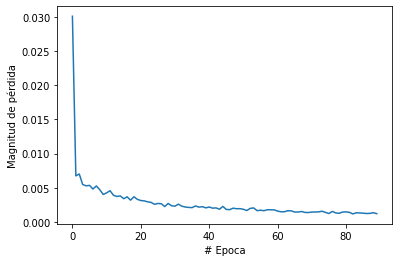

In [ ]:
#observar proceso de aprendizaje 
import matplotlib.pyplot as plt
plt.xlabel("# Epoca")
plt.ylabel("Magnitud de pérdida")
plt.plot(regressor.history.history["loss"])

**Ajustar las predicciones y visualizar los resultados**

In [ ]:
#extracción de datos test_set
start_date2 = (datetime.now()-timedelta(50)).strftime('2022-03-01')
end_date2 = datetime.now().strftime('2022-05-31')


def get_data2(ticker):
  try:
    tickerData = yf.Ticker(key)
    stock_data = tickerData.history(period='1d', start=start_date2, end=end_date2) 
  except RemoteDataError:
    print('No data found for {t}'.format(t=ticker))
  return stock_data

In [ ]:
test_set = get_data2(key)

In [ ]:
# Obtener el valor de las acciones reales ultimo trimestre
real_stock_price = test_set.iloc[:, 1:2].values

In [ ]:
# Obtener la predicción de la acción con la RNR para Enero de 2017
dataset_total = pd.concat((train_set['Open'], test_set['Open']), axis = 0)

# Entradas
inputs = dataset_total[len(dataset_total) - len(test_set) - 60:].values
                      # ultimo dia del periodo - 60 : 20
inputs = inputs.reshape(-1,1) # vector fila a vector columna 
inputs = sc.transform(inputs) # escalado de los datos

X_test = []
for i in range(60, 123):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

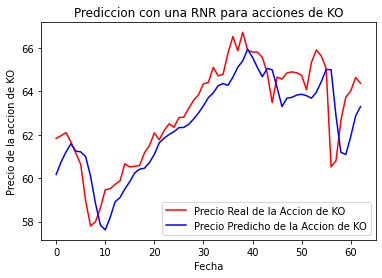

In [ ]:
# Visualizar los Resultados
plt.plot(real_stock_price, color = 'red', label = 'Precio Real de la Accion de {t}'.format(t=key))
plt.plot(predicted_stock_price, color = 'blue', label = 'Precio Predicho de la Accion de {t}'.format(t=key))
plt.title("Prediccion de tendencia acciones de {t}".format(t=key))
plt.xlabel("Fecha")
plt.ylabel("Precio de la accion de {t}".format(t=key))
plt.legend()
plt.show()

In [ ]:
# guardar modelo
import pickle

filename = '/content/drive/MyDrive/Red neuronal recurrente/rnr_model1.sav'
pickle.dump(regressor, open(filename, 'wb'))

# cargar modelo
loaded_model = pickle.load(open(filename, 'rb'))

